# Laboratorium 4 (Część II) - Detekcja krawędzi, Algorytm Canny'ego


W ramach laboratorium zostanie zaimplementowany jeden z najbardziej znanych algorytmów detekcji krawędzi - Algorytm Canny'ego.
Zacznijmy od importu przydatnych bibliotek oraz wygenerowania syntetycznego obrazu.

In [1]:
import numpy as np
from math import exp, pow
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import feature
from skimage import filters
from scipy import ndimage as nd
from scipy import signal as sig
import queue
%matplotlib inline

y_size, x_size = 256, 256
image = np.zeros((y_size, x_size))
image[100:200, 100:200] = 1

image = image + np.random.randn(y_size, x_size)*0.02

Algortym Canny'ego jest zaimplementowany w bibliotece skimage.

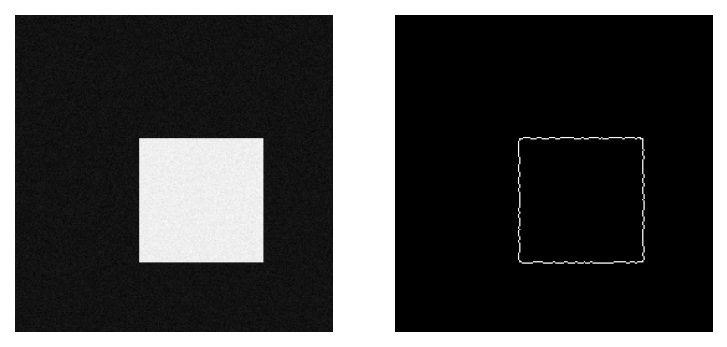

In [2]:
skimage_canny = feature.canny(image)
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(skimage_canny, cmap='gray')
plt.axis('off')
plt.show()


Celem laboratorium jest samodzielna implementacja przedstawionego algorytmu.
Uwaga: wyniki mogą różnić się od przedstawionych powyżej w zależności od przyjętych założeń i wewnętrznej implementacji filtracji Gaussa oraz doboru progu dolnego po algorytmie Otsu.
Szkielet funkcji będzie wyglądać następująco:


In [ ]:
def canny(image, sigma=1.0):
    """
    1) Dokonaj filtracji obrazu filtrem Gaussa o zadanej sigmie
    2) Wyznacz przybliżenie gradientu (jego magnitude oraz kąt) za pomocą filtru Sobela
    3) Przeprowadź "non_maximum_supression" korzystając z magnitudy i kąta gradientu, wyznaczając tym samym potencjalnie krawędzie.
    4) Dokonaj podwójnego progowania potencjalnych krawędzi aby wyznaczyć krawędzie silne oraz krawędzie słabe.
    5) Przeproważ histerezę krawędzi, zwróć wynik.
    """
    edges = None
    return None

Powyższa funkcja będzie się składać z następujących podfunkcji:

In [3]:
def gaussian_smoothing(image, sigma):
  size = int(2*2.54*sigma + 1)
  gausskernel = np.zeros((size, size), np.float32)

  for i in range(size):
    for j in range(size):
      norm = (i-1)**2 + (j-1)**2
      gausskernel[i,j] = np.exp(-norm/(2 * sigma**2)) / 2 * np.pi * sigma**2

  kernel = gausskernel/np.sum(gausskernel)

  return nd.convolve(image, kernel)

In [4]:
def calculate_gradients(image):
    """
    TO DO - Funkcja powinna zwrócić magnitude i kąt gradientu
    0.5p
    """

    Sx = np.array([[1, 0,-1],
                   [2, 0,-2],
                   [1, 0,-1]])

    Sy = np.array([[1, 2, 1] ,
                   [0, 0, 0], 
                   [-1,-2,-1]])

    y_gradient = nd.convolve(image, Sy)
    x_gradient = nd.convolve(image, Sx)

    gradient_magnitude = np.sqrt(x_gradient**2 + y_gradient**2)
    gradient_angle = np.arctan2(y_gradient, x_gradient)

    return gradient_magnitude, gradient_angle

In [5]:
def non_maximum_supression(gradient_magnitude, gradient_angle):
  """
  TO DO - funkcja powinna wyznaczyć potencjalnie krawędzie korzystając z magntiudy i kąta gradientu
  0.5p
    
  """
  potential_edges = np.zeros(gradient_magnitude.shape)

  for i in range(potential_edges.shape[0]-1):
    for j in range(potential_edges.shape[1]-1):

        # 0 degrees
        if abs(gradient_angle[i,j]) >= np.pi*7/8 or abs(gradient_angle[i,j]) < np.pi/8:
          if gradient_magnitude[i,j] >= gradient_magnitude[i,j+1] and gradient_magnitude[i,j] >= gradient_magnitude[i, j-1]:
            potential_edges[i,j] = gradient_magnitude[i,j]

        # 45 degrees
        if abs(gradient_angle[i,j]) >= np.pi/8 and abs(gradient_angle[i,j]) < np.pi*3/8:
          if gradient_magnitude[i,j] >= gradient_magnitude[i-1, j+1] and gradient_magnitude[i,j] >= gradient_magnitude[i+1,j-1]:
            potential_edges[i,j] = gradient_magnitude[i,j]

        # 90 degrees
        if abs(gradient_angle[i,j]) >= np.pi*3/8 and abs(gradient_angle[i,j]) < np.pi*5/8:
          if gradient_magnitude[i,j] >= gradient_magnitude[i-1,j] and gradient_magnitude[i,j] >= gradient_magnitude[i+1,j]:
            potential_edges[i,j] = gradient_magnitude[i,j]

        # 135 degrees
        if abs(gradient_angle[i,j]) >= np.pi*5/8 and abs(gradient_angle[i,j]) < np.pi*7/8:
          if gradient_magnitude[i,j] >= gradient_magnitude[i-1,j-1] and gradient_magnitude[i,j] >= gradient_magnitude[i+1,j+1]:
            potential_edges[i,j] = gradient_magnitude[i,j]

  return potential_edges

In [45]:
img = color.rgb2gray(io.imread("CT_lungs.png"))
img = gaussian_smoothing(img, 3)
mag, theta = calculate_gradients(img)
edges = non_maximum_supression(mag, theta)


hist, bins = np.histogram(edges.ravel(), bins=25)

w1 = np.cumsum(hist)
w2 = np.cumsum(hist[::-1])[::-1] 

w3 = w1*bins[1:]/w1
w4 = w2*bins[1:]/w2

idx = np.argmax( w1[:-1] * w2[1:] * (w3[:-1] - w4[1:])**2)

print(bins[idx+1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


[2.69017497e+07 1.52335289e+07 1.00511062e+07 7.80394029e+06
 6.19071515e+06 5.35029918e+06 4.71064460e+06 4.18713230e+06
 3.77167950e+06 3.45398785e+06 3.12722930e+06 2.83442851e+06
 2.57390566e+06 2.19264662e+06 1.71052144e+06 1.20799681e+06
 7.96860109e+05 5.31046782e+05 3.59933264e+05 2.51466842e+05
 2.04822785e+05 1.21972414e+05 3.62202059e+04 9.53242281e+03]
0.053106749832756525


In [46]:
def otsu_threshold(image):
    """
    TO DO - automatycznie wyznacz próg górny implementująć algorytm Otsu
    0.5p
    """
    hist, bins = np.histogram(image.ravel())

    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1] 

    w3 = w1*bins[:-1]/w1
    w4 = w2*bins[1:]/w2

    idx = np.argmax( w1[:-1] * w2[1:] * (w3[:-1] - w4[1:])**2)
    return bins[idx+1]

def double_threshold(potential_edges, gradient_magnitude):
    """
    TO DO  - podwójne progowanie wyznaczające krawędzie słabe poraz krawędzie mocne. Wyznacz próg górny korzystajac z otsu_threshold, a próg dolny poprzez podzielenie progu górnego przez 3
    0.5p
    """
    high_threshold = otsu_threshold(potential_edges) #filters.threshold_otsu(potential_edges)
    low_threshold = high_threshold / 3

    strong_edges = potential_edges > high_threshold
    weak_edges = np.logical_and(potential_edges > low_threshold, potential_edges < high_threshold)
    return strong_edges, weak_edges

In [7]:
def edge_hysteresis(strong_edges, weak_edges):
    """
    TO DO - dokonaj histerezy krawędzi silnych i słabych. Powinny pozostać tylko krawędzie silne oraz te krawędzie słabe, które są połączone z jakąkolwiek krawędzią silną (również przez krawędź słabą)
    0.5p
    Wskazówka: Funkcja będzie niemal identyczna z algorytmem rozrostu obszarów w wersji lokalnej z poprzedniego laboratorium
    """
    pixel_queue = queue.Queue()

    y, x = np.where(strong_edges == 1)
    coordinates = list(zip(y, x))
    for i in coordinates:
      pixel_queue.put(i)

    visited = set()
    edges = strong_edges.copy()
    y_size, x_size = image.shape

    def get_neighbours(coordinate):
        indices = [-1, 0, 1]
        results = list()

        for x in indices:
          for y in indices:
            x_index = max(min(coordinate[1] + x, x_size - 1), 0)
            y_index = max(min(coordinate[0] + y, y_size - 1), 0)
            results.append((y_index, x_index))

        return results

    while not pixel_queue.empty():
        cc = pixel_queue.get()
        
        if weak_edges[cc] or strong_edges[cc]:
          edges[cc] = True
        else:
          continue

        neighbours = get_neighbours(cc)
        for i in neighbours:
          if i in visited:
            continue
          else:
            pixel_queue.put(i)
            visited.add(i)

    return edges

Finalnie korzystając z powyższych funkcji zaimplementuj funkcję canny:

In [8]:
def canny(image, sigma=1.0):

    image = gaussian_smoothing(image, sigma)
    mag, theta = calculate_gradients(image)
    edges = non_maximum_supression(mag, theta)
    strong, weak = double_threshold(edges, mag)

    his = edge_hysteresis(strong, weak)

    return his

Porównaj działanie zaimplementowanej funkcji na wygenerowanym oraz wczytanym obrazie:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


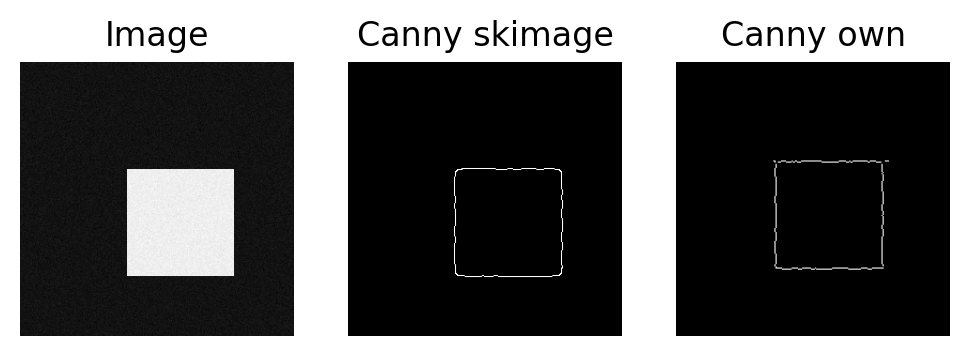

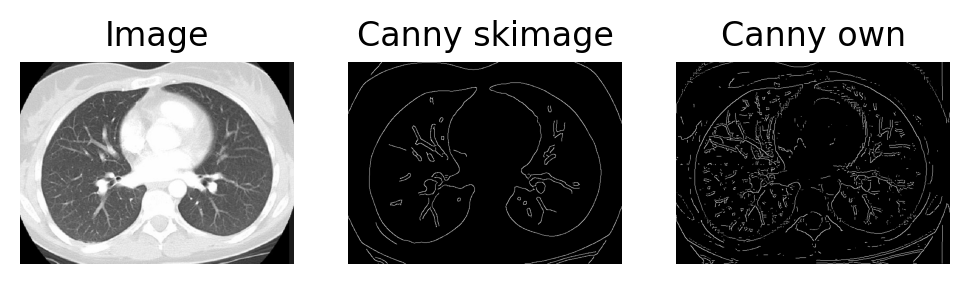

In [47]:
images = [image, color.rgb2gray(io.imread("CT_lungs.png"))] 
# Krawędzie mają grubość jednego pixela, nie wszystkie muszą być widoczne (ustawienia wyświetlania). Aby zobaczyć wszystkie krawędzie zwiększ dpi rysunku.
for current_image in images:
    skimage_canny = feature.canny(current_image, sigma=3)
    own_canny = canny(current_image, sigma=3)
    plt.figure(dpi=200)
    plt.subplot(1, 3, 1)
    plt.imshow(current_image, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(skimage_canny, cmap='gray')
    plt.title("Canny skimage")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(own_canny, cmap='gray')
    plt.title("Canny own")
    plt.axis('off')
    plt.show()

Wyniki poszczególnych etapów zostały zaprezentowane poniżej:

Filtracja Gauss (sigma=3):

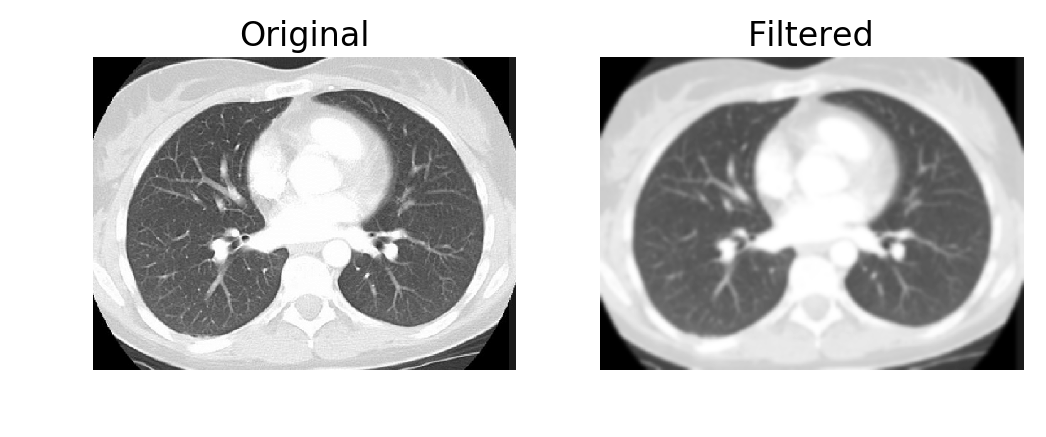

Magnituda/kąt gradientu:

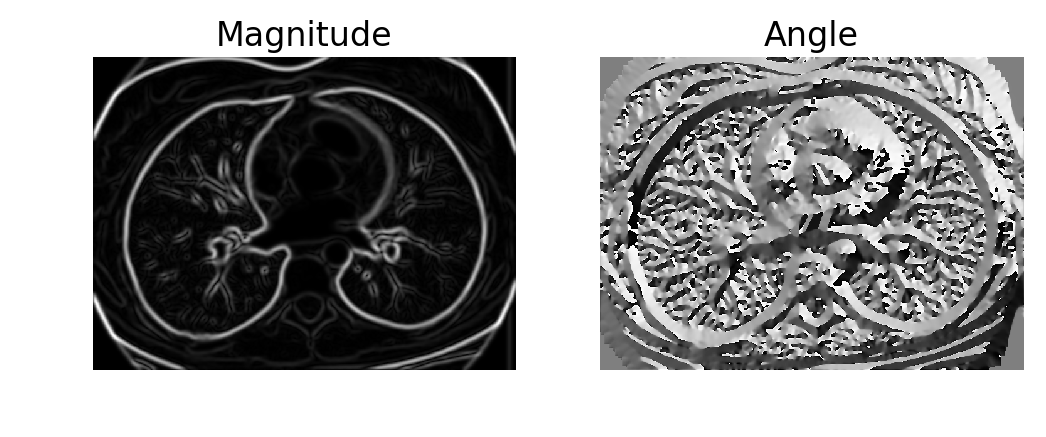

Non-maximum supression:

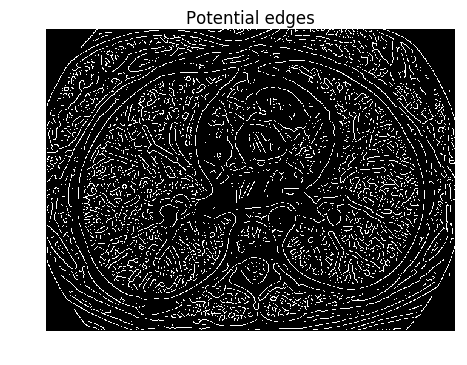

Podwójne progowanie:

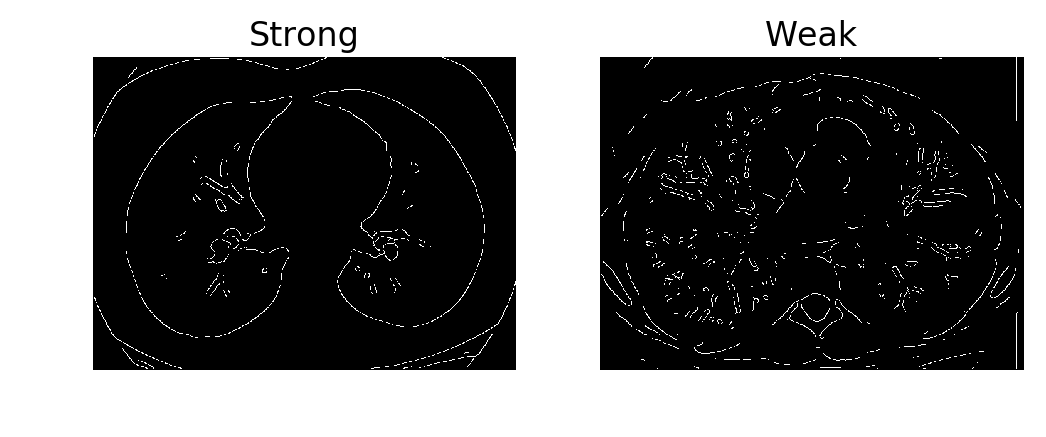

Histereza krawędzi:

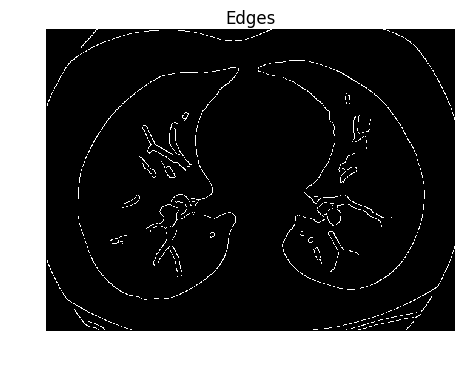